In [1]:
from counter import counter
from common_imports import *
from pathlib import Path
from csv import DictReader

ModuleNotFoundError: No module named 'counter'

In [9]:
from common_imports import *
import regex as re

In [10]:
path = "C:/Users/amcga/Downloads/econ WoS stratified top 20k"

In [11]:
#%pip install wosfile

In [19]:
target_N = 1500

# what terms

In [12]:
cc = counter('count-trends-top20k-strat30-WoS-econ')

Loading count-trends-top20k-strat30-WoS-econ from disk...


In [13]:
cc.summarize()

[(('fy', 't'), (151, 235352)), (('fj', 't'), (713, 235352)), (('fy',), (151,)), (('t',), (235352,)), (('fj',), (713,))]


In [20]:
cc.counts[('t',)]

array([374, 42, 6, ..., 0, 0, 0], dtype=object)

In [21]:
topis = np.argsort( cc.counts[('t',)] )[-150:]
print(", ".join( [k for k,i in cc.ids['t'].items() if i in topis] ))

competition, theory, theory-of, to-the, taxation, returns, and-economic, economic, of-the, in-the, social, under, international, utility, quality, prices, problem, demand, approach, american, industrial, business, and-the, problems, market, distribution, on-the, value, between, unemployment, price, changes, economics, economics-of, production, state, capital, investment, analysis, analysis-of, supply, foreign, urban, money, effects, effects-of, trade, labor, policies, banking, states, growth, general, welfare, effect, effect-of, agricultural, behavior, survey, theory-and, change, exchange, british, for-the, public, demand-for, labour, income, financial, monetary, policy, history, corporate, the-united, united, united-states, credit, productivity, pricing, political, economy, application, power, system, study, study-of, the-case, development, wages, government, role-of, industry, costs, evidence, dynamic, rates, history-of, stock, management, research, insurance, world, regulation, empl

In [22]:
terms_to_keepi = set(np.argsort( cc.counts[('t',)] )[-500:])
terms_to_keep = [k for k,i in cc.ids['t'].items() if i in terms_to_keepi] 

In [23]:
terms = cc.items('t')
counts = np.array([ cc(t=t) for t in terms ])
cdict = {t:cc(t=t) for t in terms}

In [24]:
print(len(terms), 'terms, total')

201594 terms, total


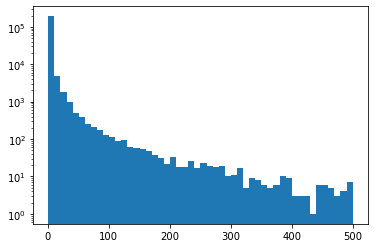

In [25]:
plt.hist(counts[counts<500], bins=50, log=True);

In [26]:
tup1 = [x for x in terms if '-' not in x]
tup2 = [x for x in terms if '-' in x]

In [27]:
tup1_top = sorted(tup1, key=lambda x:cdict[x])[-target_N//2: ]
tup2_top = sorted(tup2, key=lambda x:cdict[x])[-target_N//2: ]

In [28]:
terms_to_keep = tup1_top + tup2_top

In [29]:
len(terms_to_keep)

1500

In [30]:
print(sample(terms_to_keep, 20))

['cooperative', 'workers', 'in-industry', 'india', 'solution', 'cyclical', 'relation-between', 'case-for', 'foreign', 'in-rural', 'special', 'and-industry', 'and-some', 'wealth-and', 'lifecycle', 'the-new', 'supply-and', 'model', 'simultaneous', 'without']


In [31]:
with open('terms_to_keep.econ.pickle', 'wb') as outf:
    pickle.dump(terms_to_keep, outf)

# helper code

In [32]:
stopwords = set()

def get_tups(s, whitelist=None, stopwords=None):
    
    if stopwords is None:
        stopwords = set()
    
    sp = s.lower() # debating lowercaseing..
    sp = re.sub("[^a-zA-Z\s]+", "", sp)  # removing extraneous characters
    sp = re.sub("\s+", " ", sp)  # removing extra characters
    sp = sp.strip()
    sp = sp.split()  # splitting into words

    #sp = [x for x in sp if x not in stopwords]  # strip stopwords... not yet though!
    # sp = [x for x in sp if len(x) >= 3 ] # strip short words # don't do this now, we need these for tuples.

    # print(len(tups),c['contextPure'], "---", tups)

    # keep everything in order
    tups = ["-".join(list(x)) for x in zip(sp[:-1], sp[1:])]  # two-word *ordered* tuples
    intermingle = [ sp[i//2] if i%2==0 else tups[(i-1)//2] for i in range(2*len(sp)-1) ]
    
    intermingle = [x for x in intermingle if len(x) >= 5 ] # strip short words
    if stopwords is not None:
        intermingle = [x for x in intermingle if x not in stopwords]
    if whitelist is not None:
        intermingle = [x for x in intermingle if x in whitelist]
    
    return intermingle

get_tups("This is an example of the tuples we are processing...")

['this-is',
 'is-an',
 'an-example',
 'example',
 'example-of',
 'of-the',
 'the-tuples',
 'tuples',
 'tuples-we',
 'we-are',
 'are-processing',
 'processing']

In [33]:
def count(counter, values, terms, combinations):
    
    term_pair_combinations = [x for x in combinations if ('t1' in x or 't2' in x)]
    single_term_combinations = [x for x in combinations if not ('t1' in x or 't2' in x)]
    
    for i1,t1 in enumerate(terms):
        val = dict(values)
        val['t'] = t1
        cc.cnt(val, combinations=single_term_combinations)

        if len(term_pair_combinations):
            for t2 in tups[i1+1:i1+1+250]:
                val = dict(values)
                val['t1'] = t1
                val['t2'] = t2
                cc.cnt(val, combinations=term_pair_combinations)
    

In [34]:
with open('terms_to_keep.econ.pickle', 'rb') as inf:
    terms_to_keep = pickle.load(inf)

# Count

In [35]:
import glob
import wosfile
from collections import Counter

# Create a list of all relevant files. Our folder may contain multiple export files.
files = glob.glob(path + "/**/*.txt")

cc = counter()

# wosfile will read each file in the list in turn and yield each record
# for further handling
for i, rec in enumerate(wosfile.records_from(files)):
    
    if i % 10000 == 0:
        print(f'Record {i:,}')
        cc.summarize()
    # Records are very thin wrappers around a standard Python dict,
    # whose keys are the WoS field tags.
    # Here we look at the SC field (subject categories) and update our counter
    # with the categories in each record.

    tups = get_tups( rec.get('TI'), whitelist=terms_to_keep )
    year = int(rec.get('PY'))
    journal = rec.get('SO').lower()
    
    count(
        cc,
        values = {
            'fy': year,
            'fj': journal,
        },
        terms = tups,
        combinations = [
            ('fy','t'),
            ('fj','t'),
            ('fy',),
            ('t',),
            ('fj',),
            ('t1','t2'),
            #('fj','t1','t2'),
            ('fy','t1','t2')
        ]
    )

Blank counter with no name
Record 0
[]
Record 10,000
[(('fy', 't'), (33, 1391)), (('fj', 't'), (12, 1391)), (('fy',), (33,)), (('t',), (1391,)), (('fj',), (12,)), (('t1', 't2'), (1391, 1391)), (('fy', 't1', 't2'), (33, 1391, 1391))]
Record 20,000
[(('fy', 't'), (63, 1738)), (('fj', 't'), (188, 1738)), (('fy',), (63,)), (('t',), (1738,)), (('fj',), (188,)), (('t1', 't2'), (1738, 1738)), (('fy', 't1', 't2'), (63, 1738, 1738))]
Record 30,000
[(('fy', 't'), (63, 1738)), (('fj', 't'), (235, 1738)), (('fy',), (63,)), (('t',), (1738,)), (('fj',), (235,)), (('t1', 't2'), (1738, 1738)), (('fy', 't1', 't2'), (63, 1738, 1738))]
Record 40,000
[(('fy', 't'), (97, 1738)), (('fj', 't'), (235, 1738)), (('fy',), (97,)), (('t',), (1738,)), (('fj',), (235,)), (('t1', 't2'), (1738, 1738)), (('fy', 't1', 't2'), (97, 1738, 1738))]
Record 50,000
[(('fy', 't'), (97, 1738)), (('fj', 't'), (235, 1738)), (('fy',), (97,)), (('t',), (1738,)), (('fj',), (235,)), (('t1', 't2'), (1738, 1738)), (('fy', 't1', 't2'), (9

In [36]:
cc.save_counts('count-cooc-top20k-strat30-WoS-econ')